In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
start_N = 6 #количество каналов
Tc = 37 #время между звонками клиента
Ts = 213 #время обслуживания 
global_time = 3000 #время работы

In [3]:
class Event ():
    def __init__(self, num, move_time, next_block):
        self.num = num
        self.move_time = move_time
        self.next_block = next_block
    
    
    def __repr__(self):
        ans = '{' + str(self.num) + ' ' + str(self.move_time) + ' ' + str(self.next_block) + '}'
        return ans
    
    
    

class Device ():
    def __init__(self, channels_count, channels_max):
        self.channels_count = channels_count
        self.channels_max = channels_max

        
    def add_channel(self):
        self.channels_count += 1
        
    def remove_channel(self):
        self.channels_count -= 1
        
    def device_busy(self):
        if (self.channels_count == self.channels_max):
            return (1)
        return(0)
            
            

In [4]:
def move_transact_to_CEC(FEC, CEC):
    CEC.append(FEC[0])
    FEC.pop(0)
    return(FEC, CEC)

def move_transact_to_FEC(FEC, CEC, temp_time):
    CEC[0].move_time = temp_time + uniform_generate(Ts)
    CEC[0].next_block = 2
    FEC.append(CEC[0])
    CEC.pop(0)
    return(FEC, CEC)

def exp_generate(T):
    exp_rv = sts.expon(scale = T)
    temp_time = exp_rv.rvs(size=1)
    return(temp_time[0])

def uniform_generate(T):
    uniform_rv = sts.uniform(0, 2*T)
    temp_time = uniform_rv.rvs(size=1)
    return(temp_time[0])

def change_channel_time(channels_time, channels_count, last_time_channel_change, temp_time):
    channels_time[channels_count] += temp_time - last_time_channel_change
    return(channels_time)
    
    
def change_queue_time(queue_time, CEC, last_time_queue_change, temp_time):
    if (len(CEC) > 0):
        if (CEC[len(CEC)-1].next_block != 1):
            Q_len = len(CEC)-1
        else:
            Q_len = len(CEC)
    else:
        Q_len = 0
        
    if (Q_len > (len(queue_time) - 1)):
        queue_time.append(temp_time - last_time_queue_change)
    
    else:
        queue_time[Q_len] += temp_time - last_time_queue_change
        
    return(queue_time)

Пояснения next_block:
0 - ждем захода в устройство
1 - ждет в очереди
2 - умирает

1.0 0.9999999999999998


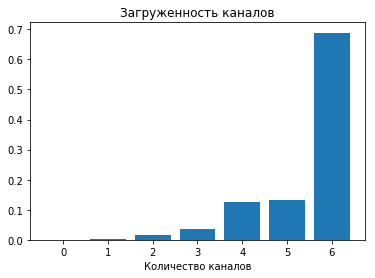

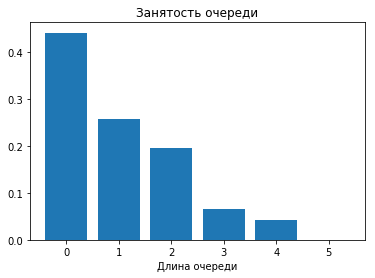

1.0 1.0


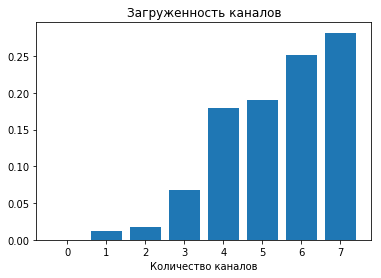

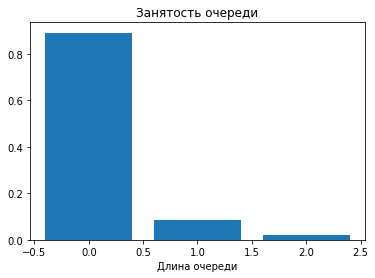

1.0000000000000002 0.9999999999999999


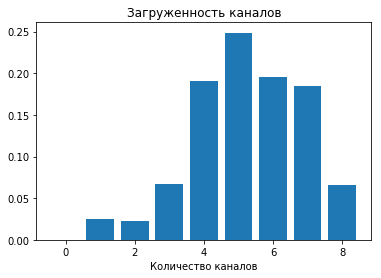

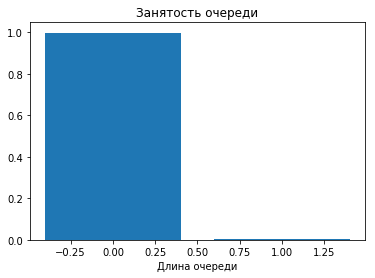

0.9999999999999999 1.0


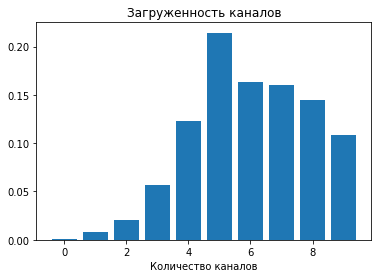

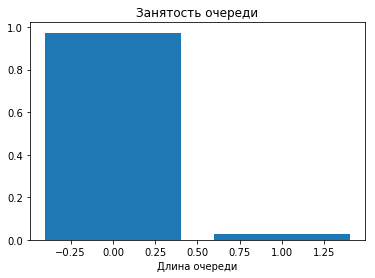

1.0 1.0


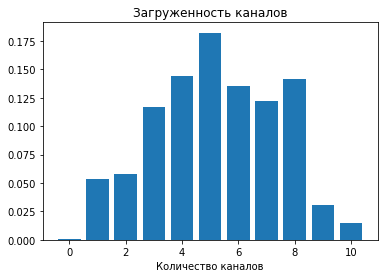

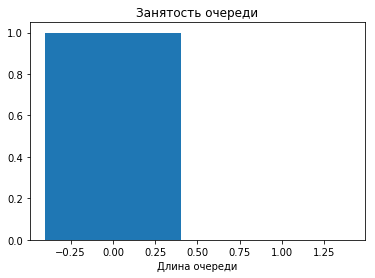

In [6]:
for N in range (start_N, start_N+5):
    temp_time = 1
    event_num = 1 #номер события
    move_time = temp_time
    FEC = [] #массив будущих событий
    CEC = [] #массив текущих событий
    channels_time = np.zeros(N+1) #массив для заполнения каналов
    queue_time = [] #массив для времени очереди 
    FEC.append(Event(event_num, move_time, 0))
    event_num += 1  #счетчик транзактов
    FEC.append(Event(event_num, global_time, 2))
    device = Device(0, N)
    last_time_channel_change = 0
    last_time_queue_change = 0
    while (temp_time <= global_time):#цикл по событиям
        #фаза коррекции таймера
        #переброс из FEC в CEC
        temp_trans = FEC[0].next_block #куда идет транзакт
        FEC, CEC = move_transact_to_CEC(FEC, CEC)
        
        #фаза просмотра
        
        #выход из устройства
        if (temp_trans == 2):
            channels_time = change_channel_time(channels_time, device.channels_count, last_time_channel_change, temp_time)
            last_time_channel_change = temp_time
            device.remove_channel()
            CEC.pop((len(CEC)-1)) #удаляем событие из системы

        #проверка занятости устройства
        if device.device_busy(): 
            queue_time = change_queue_time(queue_time, CEC, last_time_queue_change, temp_time)
            last_time_queue_change = temp_time 
            CEC[len(CEC)-1].next_block = 1  #зашедший транзакт встает в очередь 

        else:
            if (len(CEC) > 0): #отправляем транзакт в устройство
                channels_time = change_channel_time(channels_time, device.channels_count, last_time_channel_change, temp_time)
                queue_time = change_queue_time(queue_time, CEC, last_time_queue_change, temp_time) 
                last_time_channel_change = temp_time
                last_time_queue_change = temp_time
                move_transact_to_FEC(FEC, CEC, temp_time) #перемещаем первый транзакт 
                device.add_channel()
                
        if (temp_trans == 0):
            new_trans = temp_time + uniform_generate(Tc)
            event_num += 1
            FEC.append(Event(event_num, new_trans, 0))

        FEC.sort(key=lambda n: n.move_time) #сортируем  
        temp_time = FEC[0].move_time
    channels_time = change_channel_time(channels_time, device.channels_count, last_time_channel_change, global_time)
    queue_time = change_queue_time(queue_time, CEC, last_time_queue_change, global_time)
    
    channels_time = [float(i/global_time) for i in channels_time]
    queue_time = [float(i/global_time) for i in queue_time]
    print(sum(channels_time), sum(queue_time))
    x_channel = [i for i in range(N+1)]
    plt.bar(x_channel, channels_time)
    plt.title("Загруженность каналов")
    plt.xlabel("Количество каналов")
    plt.show()
    x_queue = [i for i in range(len(queue_time))]
    plt.bar(x_queue, queue_time)
    plt.title("Занятость очереди")
    plt.xlabel("Длина очереди")
    plt.show()
